# Offspring Height Model

> Leveraging Python data manipulation and modeling libraries to develop a Offspring Height Prediction model from the Galton Dataset.

## Links
<ul>
    <li><a href="https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/T0HSJ1">Galton Dataset</a></li>
</ul>

## Importing Libraries and Loading Data

Using the Pandas library to read the .dta stata file. Make sure to fix any errors with the dataset that will cause you problems down the line!

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import joblib
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR

In [2]:
df = pd.read_stata("./galton.dta")

# fix small error with data
df.loc[890:, "family"] = 205

display(df.head())

,family,father,mother,gender,height,kids,male,female
0,1,78.5,67.0,M,73.199997,4,1.0,0.0
1,1,78.5,67.0,F,69.199997,4,0.0,1.0
2,1,78.5,67.0,F,69.000000,4,0.0,1.0
3,1,78.5,67.0,F,69.000000,4,0.0,1.0
4,2,75.5,66.5,M,73.500000,4,1.0,0.0


## Exploring the Data (BRIEFLY)

Checking out the dataset BEFORE creating the test set. Doing so allows you to gain a basic understanding of the data you're working with. 

However, analyzing the entire dataset before creating your test set for too long will increase the risk of <i>data snooping bias</i>, which is when you detect patterns and implement a model that overfits the dataset, but doesn't generalize well!

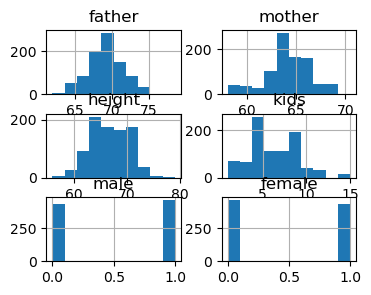

In [3]:
# inspect distributions

df_numerical = df.drop(columns=["gender"])

df_numerical.hist(figsize=(4,3))
plt.show()

## Setting aside a Test Set
Since this is a relatively small dataset, sampling randomly runs the risk of introducing significant sampling bias. For example, randomly sampling mostly men instead of an even distribution of men and women. Same thing goes for heights.

To make sure the training and test sets are representative of the entire dataset, we will employ <b>stratified sampling</b>, which is the process of partitioning the population into groups called <i>strata</i> and ensuring each dataset (train and test) contains enough of each strata. Luckily, scikit-learn can do this for us! We will stratify the gender, father, and mother features because they are important for our model.

In [4]:
def get_bins(min_val, max_val, num_bins=4):
    bins = [0]
    bins.extend([(i * ((max_val - min_val) / num_bins) + min_val) for i in range(1, num_bins)])
    bins.append(np.inf)
    return bins

df["father_height_cat"] = pd.cut(df["father"], bins=get_bins(min(df.father), max(df.father)), labels=[1,2,3,4])
df["mother_height_cat"] = pd.cut(df["mother"], bins=get_bins(min(df.mother), max(df.mother)), labels=[1,2,3,4])

# combine all stratified columns into one column
df["fhc_mhc_ml"] = df["father_height_cat"].astype('str') + '_' + df["mother_height_cat"].astype('str') + '_' + df["male"].astype('str')

# stratify
train, test = train_test_split(df, test_size=0.2, stratify=df["fhc_mhc_ml"], random_state=3)

# drop the cat columns - they were only used for stratification
for set_ in [df, train, test]:
    set_.drop(columns=["father_height_cat", "mother_height_cat", "fhc_mhc_ml"], inplace=True)

## Further Exploration

After setting aside the test set, you can explore the training set as much as you want.

I want to gain a better understanding of which features correlate well with the (offspring) height. So, I created a correlation matrix and indexed into the "height" column, which provides a Pandas series quantifying how well each feature correlates with the offspring height.

As expected, the father height, mother height, and gender all have a clear relationship with the offspring height.

In [5]:
corr_matrix = df_numerical.corr()

corr_matrix["height"].sort_values(ascending=False)

height    1.000000
male      0.714258
father    0.275355
mother    0.201655
kids     -0.126910
family   -0.284867
female   -0.714258
Name: height, dtype: float64

## Preprocessing

Preprocessing training data involves (a) handling erroneous datapoints and (b) making the data more amenable to ML algorithms.

Luckily, this dataset doesn't have any erroneous datapoints, so missing data handling will not be necessary! 

However, as seen by the plots above, some of the feature distributions have heavy tails and don't exhibit a nice normal bell curve, which most ML algorithms work best with. So, we will need to apply some transformations to each feature to make sure it exhibits a nice bell curve. Sometimes, this isn't possible, in which case other strategies will be needed (Guassian RBF for multimodal, bucketizing, etc.). The one-hot encoded male and female features will not need to be transformed.

Additionally, the features are scaled differently. For example, the Male and Female features are one-hot encoded. However, the height features are measured in inches, so they are an order of magnitude larger than the Male and Female features! This will cause (most) ML algorithms to overreact to changes in height, but underreact to changes in gender. Thus, to make sure all the features are considered equally, they will need to be scaled to be within the same order of magnitude. In this case, we want to scale the heights to be within -1 and 1 (with exception of outliers).

Scikit-learn makes preprocessing easy with their pipelines feature.

In [6]:
father_heights_pipeline = make_pipeline(
    FunctionTransformer(np.sqrt, feature_names_out="one-to-one"),
    StandardScaler())

def powerOfFour(A):
    return np.power(A, 4)

mother_heights_pipeline = make_pipeline(
    FunctionTransformer(powerOfFour, feature_names_out="one-to-one"),
    StandardScaler())

preprocessing = ColumnTransformer([
    ("father", father_heights_pipeline, ["father"]),
    ("mother", mother_heights_pipeline, ["mother"]),
    ("pass", "passthrough", ["male", "female"])]
)

## Training and Validation

Here, I select a couple of ML algorithms and build some models. I evaluate the performance of each model using the scikit-learn's cross validation score, which essentially creates 10 validation/training set pairs within the training set to test the model against. This way, I can tell whether the model is overfitting its training set or underfitting.

I can also tell how consistent the model is by looking at the standard deviation of its error across all 10 tests.

### Linear Regression

As seen by the low standard deviation, the linear regression model is able to consistently generalize well to the validation set. However, it is a very simple model that is prone to underfitting, which could explain why it is 2.2 inches off on average.

### Decision Tree Regression

Decision Tree Regression is a powerful ML algorithm that can capture much more complex relationships than linear regression. However it is prone to overfitting.

Overfitting is clearly exhibited because when the model is predicting on data that it has already seen the error is much better than linear regression (1.7 inches off on average). However, when the model has to generalize to a validation set, it is 2.48 inches off on average, which means it overfits to its training set. 

### K-Nearest Neighbors

K-Nearest Neighbors is a simple yet powerful ML algorithm that can also capture complex relationships in data.

Just like with Tree Regression, it performs very well on data it has already seen. The mean squared error when tested on its training set is is 1.97 inches off on average. However, it too is prone to overfitting. As seen by the cross validation scores, the KNN model cannot generalize to the validation set. It performs slightly better than Tree Regression, but not as well as Linear Regression.

### SVM and Ridge Regression

Similar to Linear Regression, Ridge Regression contains hyperparameters that enable you to fine-tune your model. As a result, its performance is very similar to Linear Regression. SVM is different from linear regression, but it provides close to the same performance.

In [7]:
def validate(algorithm): 
    model = make_pipeline(preprocessing, algorithm)
    model.fit(train, labels)
    print("-"*20)
    print(f"TESTING {algorithm}")
    print(f"MSE on seen data: {mean_squared_error(labels, model.predict(train), squared=False)}")
    print("Cross Validation Score:")
    rmses = -cross_val_score(model, train, labels, scoring="neg_root_mean_squared_error", cv=10)
    display(pd.Series(rmses).describe())

labels = train.height

for alg in [LinearRegression(), DecisionTreeRegressor(random_state=3), KNeighborsRegressor(10), LinearSVR(), Ridge(0.5)]:
    validate(alg)

--------------------
TESTING LinearRegression()
MSE on seen data: 2.2004642486572266
Cross Validation Score:


count    10.000000
mean      2.204155
std       0.215076
min       1.980553
25%       2.036608
50%       2.135471
75%       2.327788
max       2.649221
dtype: float64

--------------------
TESTING DecisionTreeRegressor(random_state=3)
MSE on seen data: 1.737262298542847
Cross Validation Score:


count    10.000000
mean      2.478568
std       0.143765
min       2.339776
25%       2.393215
50%       2.455047
75%       2.506647
max       2.841381
dtype: float64

--------------------
TESTING KNeighborsRegressor(n_neighbors=10)
MSE on seen data: 2.082166910171509
Cross Validation Score:


count    10.000000
mean      2.298971
std       0.195939
min       2.071115
25%       2.211413
50%       2.246456
75%       2.403944
max       2.713177
dtype: float64

--------------------
TESTING LinearSVR()
MSE on seen data: 2.2022349509697015
Cross Validation Score:


count    10.000000
mean      2.213325
std       0.217648
min       1.993576
25%       2.050281
50%       2.136479
75%       2.336300
max       2.676751
dtype: float64

--------------------
TESTING Ridge(alpha=0.5)
MSE on seen data: 2.200467348098755
Cross Validation Score:


count    10.000000
mean      2.205087
std       0.214743
min       1.980693
25%       2.035959
50%       2.140928
75%       2.328505
max       2.648485
dtype: float64

### Shortlisting the Best and Fine-Tuning

After training and validating at a variety of models, I've decided to shortlist Linear Regression, Ridge, and SVM, as they generalize very well to the validation sets. While Linear Regression has no hyperparameters to play with, Ridge and SVM do. So, I can perform a grid search on a few parameter values and see which combination of hyperparameters works best! Luckily scikit-learn provides functionality for this.

In [8]:
def tune(algorithm, param_grid):
    print("-"*20)
    print(f"TUNING {algorithm}")
    pipeline = Pipeline([("preprocessing", preprocessing), ("algorithm", algorithm)])
    grid_search = GridSearchCV(make_pipeline(preprocessing, algorithm), param_grid, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(train, labels)
    results = pd.DataFrame(grid_search.cv_results_)
    params = [f"param_{i}" for i in param_grid.keys()]
    params.append("mean_test_score")
    results.sort_values(by="mean_test_score", ascending=False, inplace=True)
    results.mean_test_score = results.mean_test_score * -1
    display(results[params].head())

tuning_params = [
    (LinearSVR(), {
        "linearsvr__epsilon": [0.0, 1.0],
        "linearsvr__tol": [0.00001, 0.00005, 0.0001, 0.0005, 0.001],
        "linearsvr__C": [2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1],
        "linearsvr__max_iter": [5000]}),
    (Ridge(), {
        "ridge__alpha": [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]}),
    (LinearRegression(), {})
]

for alg, params in tuning_params:
    tune(alg, params)

--------------------
TUNING LinearSVR()


,param_linearsvr__epsilon,param_linearsvr__tol,param_linearsvr__C,param_linearsvr__max_iter,mean_test_score
3,0.0,0.0005,2.0,5000,2.212406
24,0.0,0.001,1.0,5000,2.212408
11,0.0,0.00005,1.5,5000,2.214545
10,0.0,0.00001,1.5,5000,2.214602
12,0.0,0.0001,1.5,5000,2.214682


--------------------
TUNING Ridge()


,param_ridge__alpha,mean_test_score
3,1.0,2.208531
4,2.0,2.208544
2,0.5,2.208546
1,0.2,2.208561
0,0.1,2.208567


--------------------
TUNING LinearRegression()


,mean_test_score
0,2.208534


## Evaluating on the Test Set

The best fine-tuned model is Ridge Regression with an alpha of 1.0! After sufficient fine tuning, you can see evaluate it on the test set.

In [9]:
test_features = test
test_labels = test.loc[:, "height"].copy()

final_model = make_pipeline(preprocessing, Ridge(alpha=1.0))
final_model.fit(train, labels)
final_predictions = final_model.predict(test_features)

final_rmse = mean_squared_error(test_labels, final_predictions, squared=False)

print(f"Error: {final_rmse}")
print()
squared_errors = (final_predictions - test_labels) ** 2
confidence_interval = np.sqrt(stats.t.interval(0.95, len(squared_errors) - 1, 
    loc=squared_errors.mean(), scale=stats.sem(squared_errors)))
print(f"95% Confidence Interval: {confidence_interval[0]} - {confidence_interval[1]}")

Error: 1.9345074892044067

95% Confidence Interval: 1.7202299130806096 - 2.1273099767291


## Deploying it in the Wild

A model within ~2 inches 95% of the time is pretty good! For deploying it in the wild, let's test it on myself.

Let's also save it as a .pkl file, so we can use it elsewhere.

In [10]:
# Testing model on my height

my_data = pd.DataFrame({'family': [206], 'father': [66], 'mother': [66.5], 'gender': ['M'], 'height': [68], 
                        'kids': [2], 'male': [1.0], 'female': [0.0]})

final_model.predict(my_data)[0]

joblib.dump(final_model, "model.joblib")

['model.joblib']

(I'm about 68.5", so the model was pretty accurate for me!)